# Failure Type Prediction

In this notebook the target is to predict the type of failures which can occur for a given machine in manufacaturing line. Also the project also aims to find the confidence in the predictions which can be related

## Importing files

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Reading data

In [3]:
df = pd.read_csv('predictive_maintenance.csv')
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


## Getting the info regarding the data set

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [5]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [6]:
# checking our target column, we observe that in 339 instances only, the machine failed
df['Target'].value_counts()

0    9661
1     339
Name: Target, dtype: int64

### Now let's see if any missing values and clean our data

In [7]:
df.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

### Now lets check for the outliers for tempuratures, speed, torque

[Text(0.5, 1.0, 'Normal Distribution of Tool Wear'),
 Text(0.5, 0, 'Tool wear'),
 Text(0, 0.5, 'Frequency')]

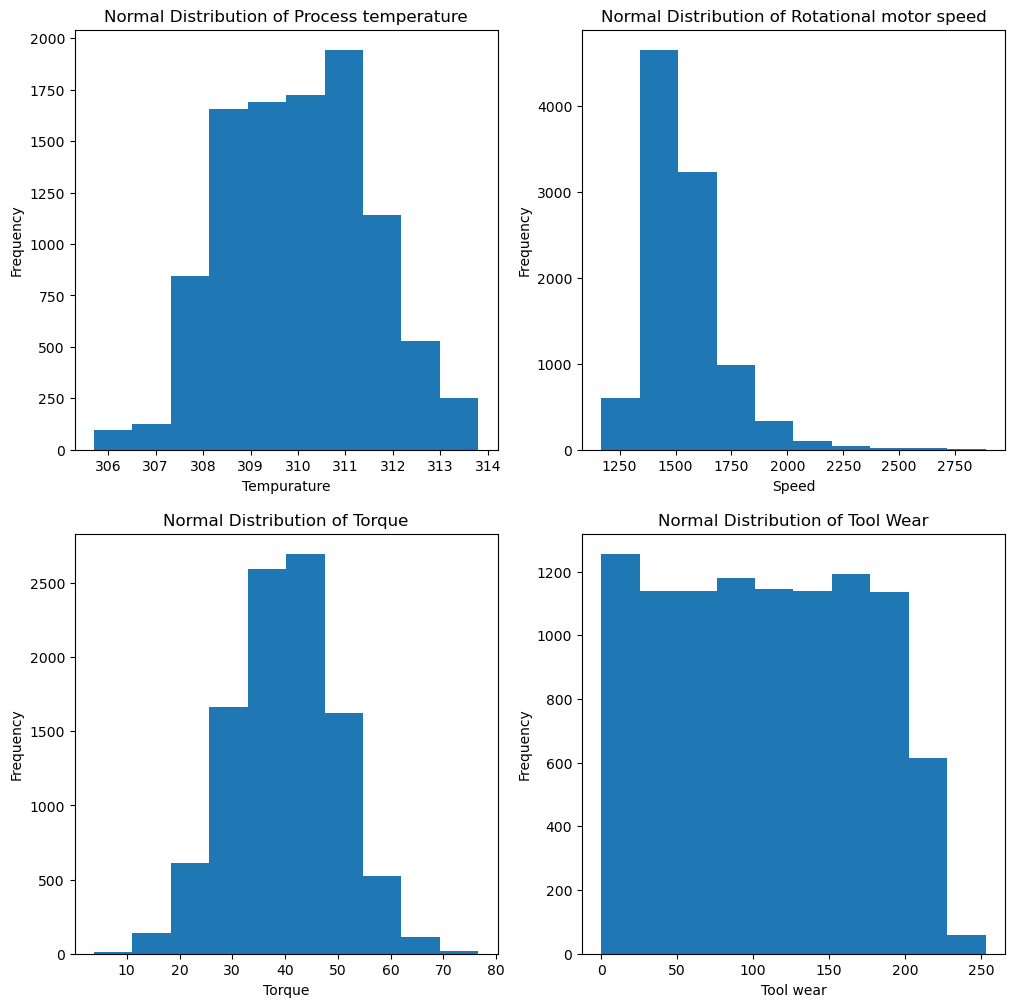

In [8]:
fig, ax = plt.subplots(2,2,figsize = (12, 12))
ax[0,0].hist(df['Process temperature [K]'])
ax[0,0].set(title = 'Normal Distribution of Process temperature',
      xlabel = 'Tempurature',
      ylabel = 'Frequency')
ax[0,1].hist(df['Rotational speed [rpm]'])
ax[0,1].set(title = 'Normal Distribution of Rotational motor speed',
      xlabel = 'Speed',
      ylabel = 'Frequency')
ax[1,0].hist(df['Torque [Nm]'])
ax[1,0].set(title = 'Normal Distribution of Torque',
      xlabel = 'Torque',
      ylabel = 'Frequency')
ax[1,1].hist(df['Tool wear [min]'])
ax[1,1].set(title = 'Normal Distribution of Tool Wear',
      xlabel = 'Tool wear',
      ylabel = 'Frequency')

We can see above that no extensive outliers are there in our dataset.

### Now lets make our data ready for modelling

In [9]:
# Having UDI and product Id doesnt help in our modelling
df['Product ID'].nunique()

10000

In [10]:
# Thus removing those columns
df = df.drop(['Product ID','UDI'],axis=1)
df

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...
9995,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,H,299.0,308.7,1408,48.5,25,0,No Failure


In [11]:
# Now lets check our last string column which is type, which we hvae turned into a category type
df['Type'] = df['Type'].astype('category')
df['Type'] = df['Type'].cat.codes
df

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,2,298.1,308.6,1551,42.8,0,0,No Failure
1,1,298.2,308.7,1408,46.3,3,0,No Failure
2,1,298.1,308.5,1498,49.4,5,0,No Failure
3,1,298.2,308.6,1433,39.5,7,0,No Failure
4,1,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...
9995,2,298.8,308.4,1604,29.5,14,0,No Failure
9996,0,298.9,308.4,1632,31.8,17,0,No Failure
9997,2,299.0,308.6,1645,33.4,22,0,No Failure
9998,0,299.0,308.7,1408,48.5,25,0,No Failure


In [12]:
# Lastly lets work with Failure Type column
df['Failure Type'] = df['Failure Type'].astype('category')
df['Failure Type'] = df['Failure Type'].cat.codes
df

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,2,298.1,308.6,1551,42.8,0,0,1
1,1,298.2,308.7,1408,46.3,3,0,1
2,1,298.1,308.5,1498,49.4,5,0,1
3,1,298.2,308.6,1433,39.5,7,0,1
4,1,298.2,308.7,1408,40.0,9,0,1
...,...,...,...,...,...,...,...,...
9995,2,298.8,308.4,1604,29.5,14,0,1
9996,0,298.9,308.4,1632,31.8,17,0,1
9997,2,299.0,308.6,1645,33.4,22,0,1
9998,0,299.0,308.7,1408,48.5,25,0,1


In [13]:
# Now we can do our modelling
df.dtypes

Type                          int8
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                  int8
dtype: object

## Now lets deep dive into exploratory data analysis

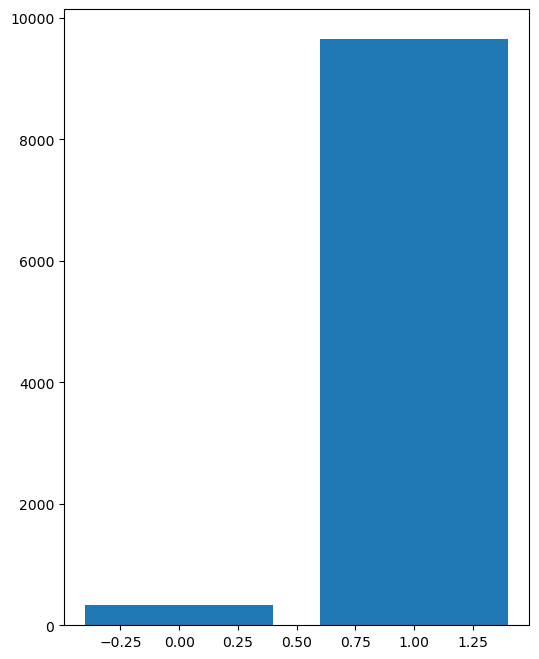

In [14]:
# Initially lets see number failed instances vs non failures
fail_counts = (df['Target']==1).value_counts()[1]
non_fail_counts = (df['Target']==1).value_counts()[0]
list_counts = [fail_counts,non_fail_counts]
fig, ax = plt.subplots(figsize=(6,8))
ax = ax.bar(range(len(list_counts)),list_counts)

as we can observe there are too many cases where there is no failure which may effect our models capability, thus, we will select only 20% of the non failing instances at random to improve data feature extraction and learning capability

In [15]:
# reducing data
df_new_0 = df[df['Target']==0].sample(frac=0.05)
df_new_1 = df[df['Target']==1].sample(frac=1)
df_new = pd.concat([df_new_1,df_new_0])
df_new.reset_index(inplace=True)
df_new.drop(['index'], axis=1,inplace=True)
df_new

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,301.9,310.4,1286,62.8,22,1,0
1,0,300.3,309.9,1394,46.7,210,1,5
2,2,298.0,308.7,1479,58.5,176,1,3
3,1,300.3,310.3,1362,60.3,206,1,2
4,1,298.8,308.9,1455,41.3,208,1,5
...,...,...,...,...,...,...,...,...
817,1,299.7,309.1,1347,55.3,139,0,1
818,1,299.0,310.1,1444,47.7,161,0,1
819,1,302.0,310.6,1361,46.7,182,0,1
820,1,297.8,307.9,1447,48.6,46,0,1


In [16]:
df = df_new

In [17]:
df_copy = df

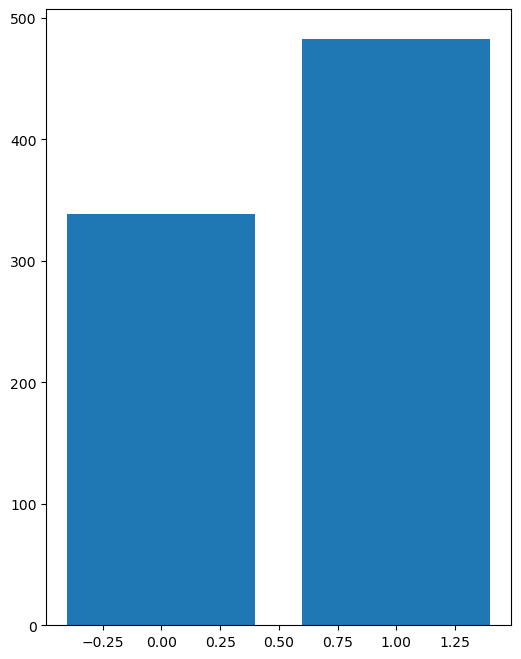

In [18]:
# Again lets see number failed instances vs non failures
fail_counts = (df['Target']==1).value_counts()[1]
non_fail_counts = (df['Target']==1).value_counts()[0]
list_counts = [fail_counts,non_fail_counts]
fig, ax = plt.subplots(figsize=(6,8))
ax = ax.bar(range(len(list_counts)),list_counts)

In [19]:
fail_counts = (df['Target']==1).value_counts()[0]
fail_counts

483

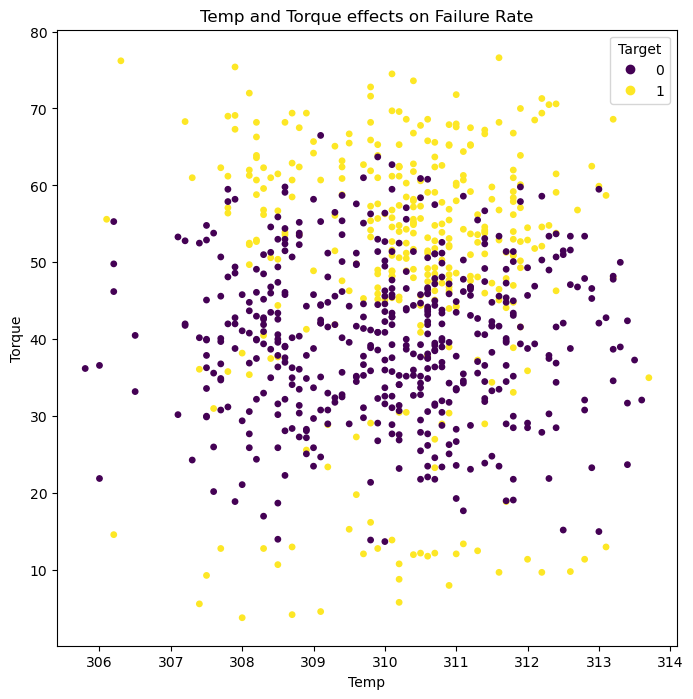

In [20]:
# first lets see how the tempurature and torque of the motor affects the failure rate
fig, ax = plt.subplots(figsize = (8,8))
scatter = ax.scatter(df_copy['Process temperature [K]'],
                     df_copy['Torque [Nm]'],
                    c = df['Target'],
                    s=15)
ax.set(title = 'Temp and Torque effects on Failure Rate',
      xlabel = 'Temp',
      ylabel = 'Torque')
ax.legend(*scatter.legend_elements(), title="Target");

From above we can observe that mostly when the torque is low or high the failure rate is high, however, the process temp at failure is uniformly spread throught.

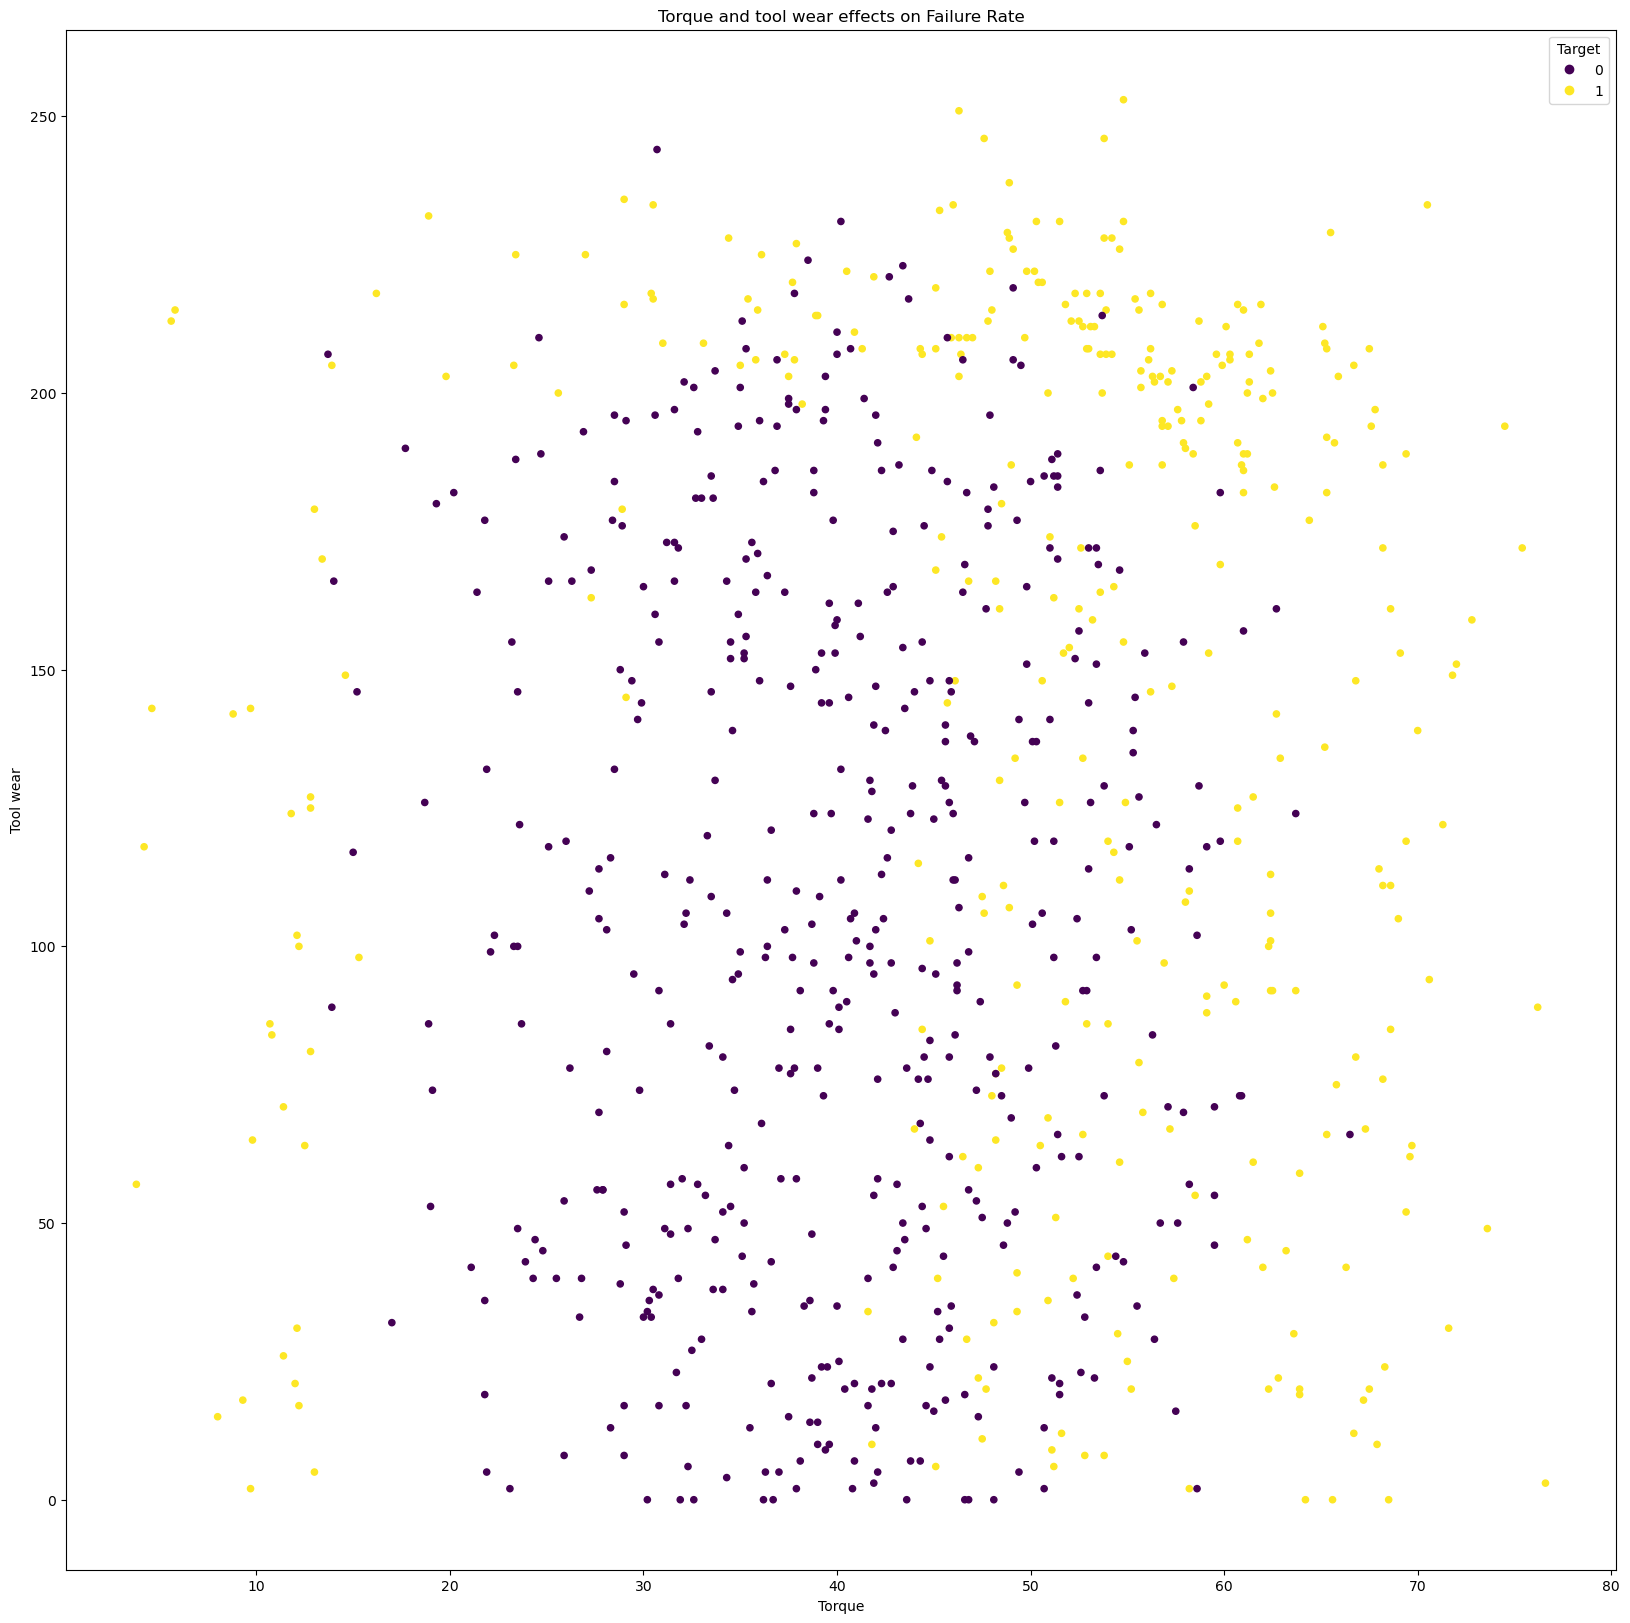

In [21]:
# observing torque and toolwear
fig, ax = plt.subplots(figsize = (20,20))
scatter = ax.scatter(df_copy['Torque [Nm]'],
                     df_copy['Tool wear [min]'],
                    c = df['Target'],
                    s=20)
ax.set(title = 'Torque and tool wear effects on Failure Rate',
      xlabel = 'Torque',
      ylabel = 'Tool wear')
ax.legend(*scatter.legend_elements(), title="Target");

Above we can observe that we have high failure rates at higher tool wear and torque

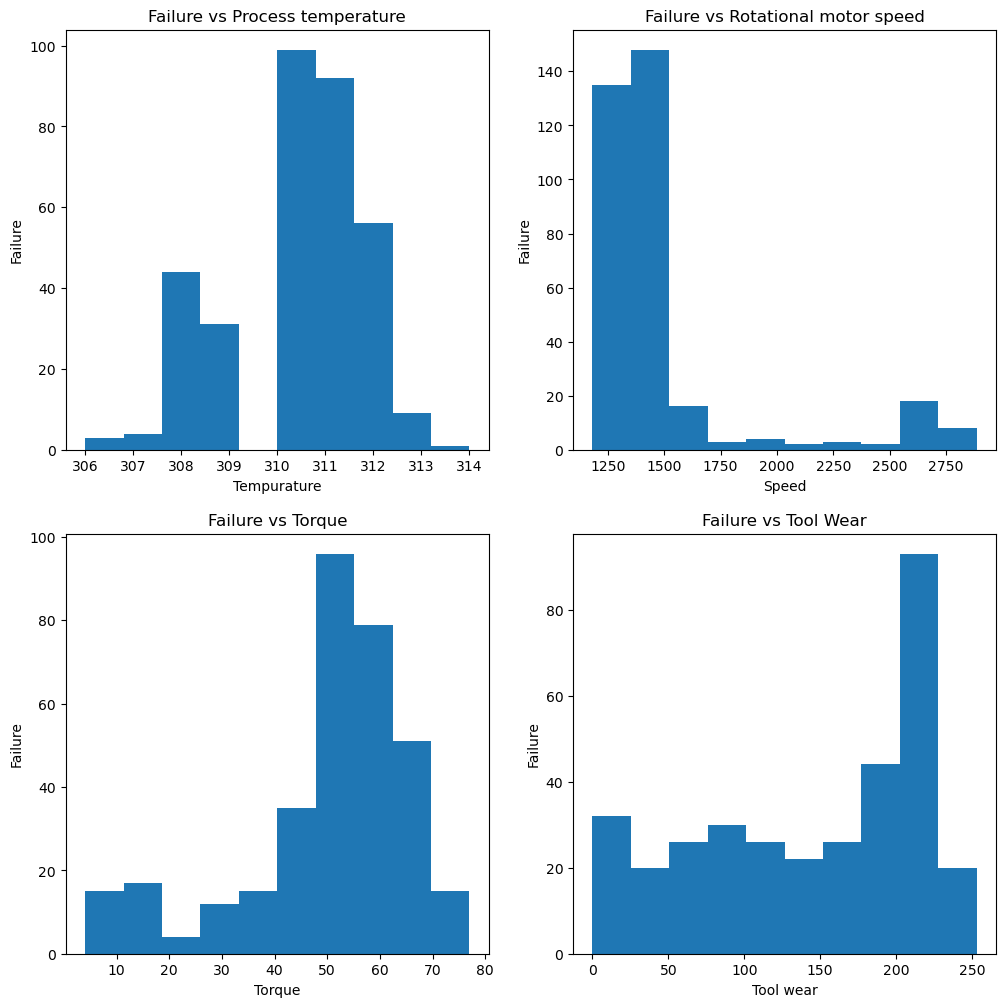

In [22]:
# Now lets see how failure rate varies with the change in tempurature, speed, torque and toolwear
fig, ax = plt.subplots(2,2,figsize = (12, 12))
ax[0,0].hist(df_copy.loc[df_copy['Target']==1]['Process temperature [K]'].T.round(0))
ax[0,0].set(title = 'Failure vs Process temperature',
      xlabel = 'Tempurature',
      ylabel = 'Failure')
ax[0,1].hist(df_copy.loc[df_copy['Target']==1]['Rotational speed [rpm]'].T.round(0))
ax[0,1].set(title = 'Failure vs Rotational motor speed',
      xlabel = 'Speed',
      ylabel = 'Failure')
ax[1,0].hist(df_copy.loc[df_copy['Target']==1]['Torque [Nm]'].T.round(0))
ax[1,0].set(title = 'Failure vs Torque',
      xlabel = 'Torque',
      ylabel = 'Failure')
ax[1,1].hist(df_copy.loc[df_copy['Target']==1]['Tool wear [min]'].T.round(0))
ax[1,1].set(title = 'Failure vs Tool Wear',
      xlabel = 'Tool wear',
      ylabel = 'Failure');

Above we can see that at what values of deterministics we get most failures of the machine.

Text(0.5, 0, 'Types of Failure')

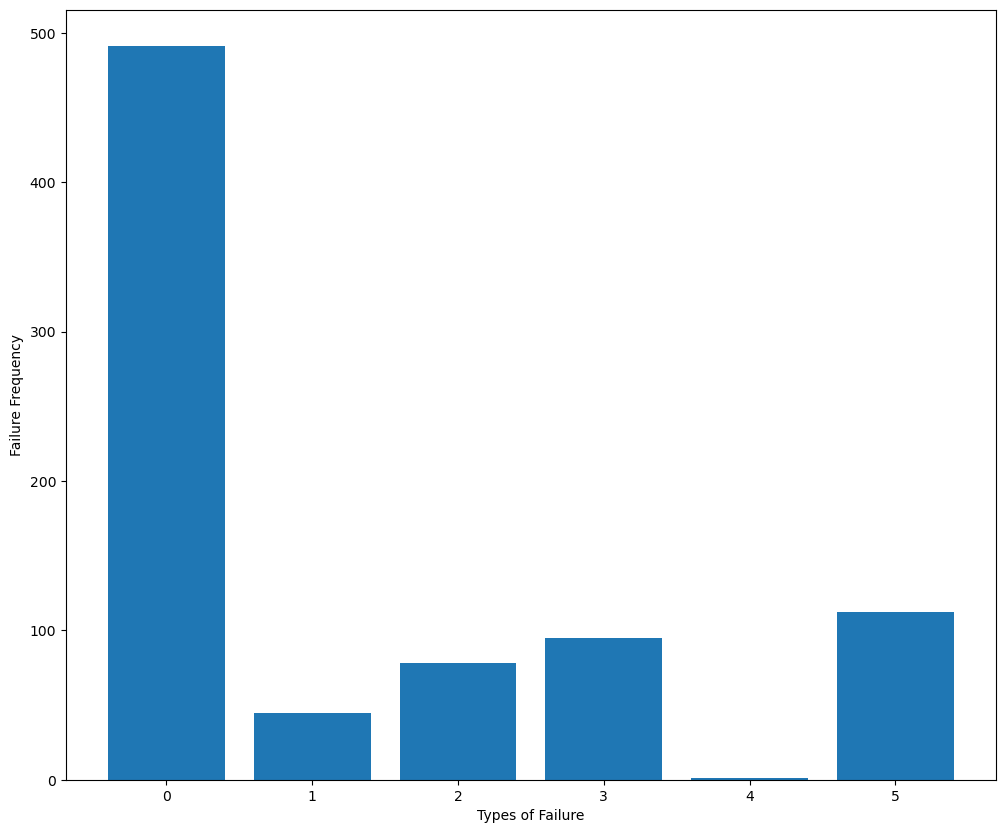

In [23]:
# Now we will observe how many types of failure are there
fig, ax = plt.subplots(figsize=(12,10))
ax = ax.bar(df_copy['Failure Type'].unique(),df_copy['Failure Type'].value_counts())
plt.ylabel("Failure Frequency")
plt.xlabel("Types of Failure")

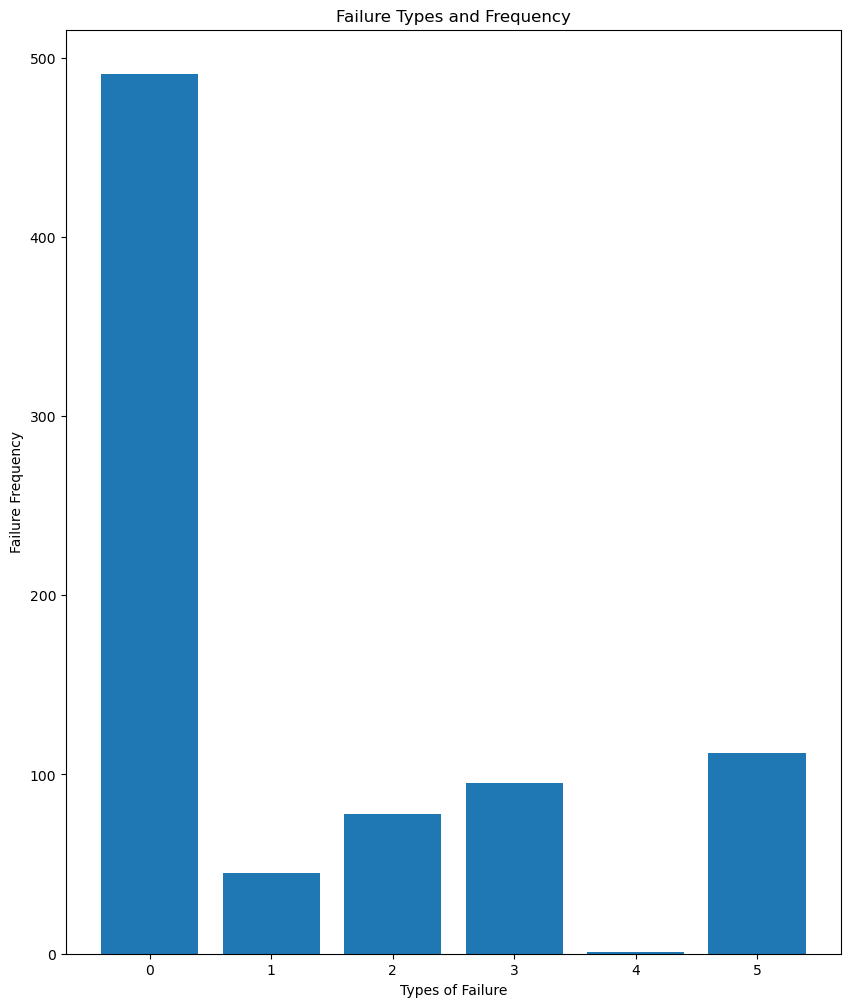

In [24]:
# Removing No Failure
fig,ax = plt.subplots(figsize=(10,12))
ax = ax.bar(df_copy[df_copy['Failure Type']!='No Failure']['Failure Type'].unique(),
           df_copy[df_copy['Failure Type']!='No Failure']['Failure Type'].value_counts())
plt.ylabel("Failure Frequency")
plt.xlabel("Types of Failure")
plt.title("Failure Types and Frequency");

## Modelling

### Data Division

In [76]:
# Dividing our data based on target and feature columns, We want more expressibilty from our model so we will try to find the Failure Type, rather than Target
X = df.drop(["Target","Failure Type"], axis=1)
y = df["Failure Type"]

# Split data into train and test
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2)

We will use LinearSVC, KNN and Random forest Classifier for our modelling and compare them baseed on their performance

### Linear SVC

In [26]:
# Instantiate and fit the model (on the training set)
ModelSVC = LinearSVC(max_iter=100, dual = False)
ModelSVC.fit(X_train, y_train)

# Check the score of the model (on the test set)
ModelSVC.score(X_test, y_test)

0.9212121212121213

### KNN

In [27]:
# Initialise the model
ModelKNN = KNeighborsClassifier(n_neighbors=5,p=2,metric='euclidean')
ModelKNN.fit(X_train, y_train)

# Check the score of the model
ModelKNN.score(X_test, y_test)

0.7272727272727273

### Ensemble Model (Random Forest)

In [28]:
# initialise
ModelRF = RandomForestClassifier()
ModelRF.fit(X_train, y_train)

# Check performance
ModelRF.score(X_test, y_test)

0.8909090909090909

#### Observing the Feature Importance

Text(0.5, 0, 'Feature Importance')

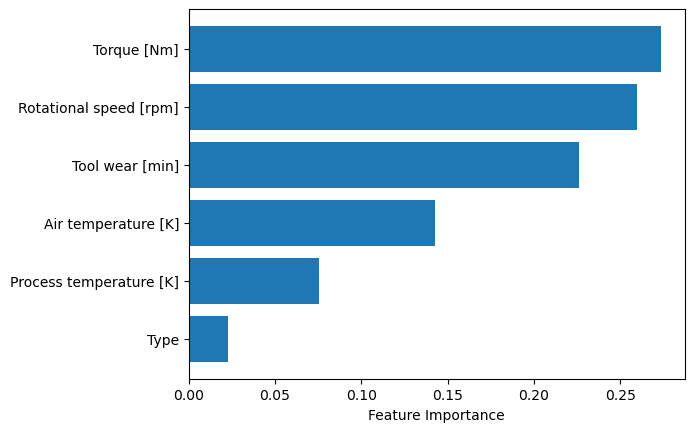

In [29]:
sort = ModelRF.feature_importances_.argsort()
plt.barh(df.columns[sort], ModelRF.feature_importances_[sort])
plt.xlabel("Feature Importance")

## Model Evaluation

Now we will see and compare the performance of all three models to see which one is the best for our application of predicting failure

### First we will be doing cross-validation score check

In [30]:
cvSVC = np.mean(cross_val_score(ModelSVC,X,y,cv=5))
cvKNN = np.mean(cross_val_score(ModelKNN,X,y,cv=5))
cvRF = np.mean(cross_val_score(ModelRF,X,y,cv=5))

# Storing the CV Scores in a Dict
Dict = {'SVC Score':cvSVC,
       'KNN Score':cvKNN,
       'RF Score':cvRF}

C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [31]:
Dict.values()

dict_values([0.8966149297856616, 0.731189948263119, 0.8954175905395418])

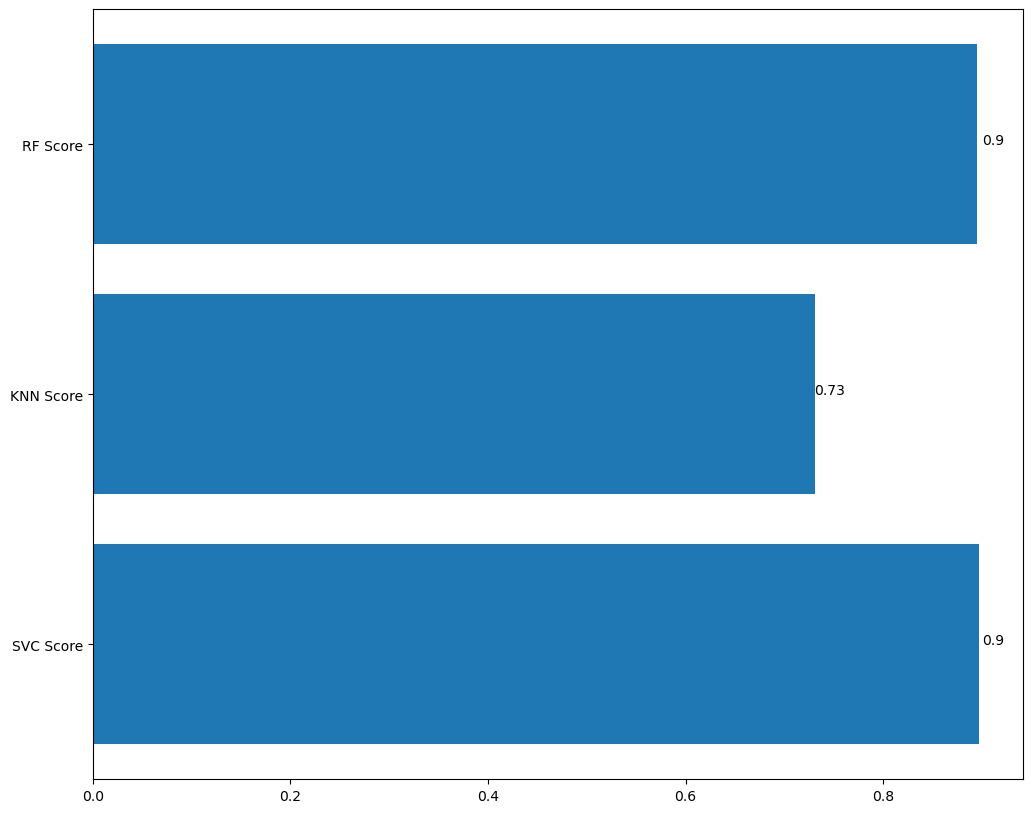

In [32]:
fig, ax = plt.subplots(figsize = (12,10))
ax = plt.barh(range(len(Dict)),list(Dict.values()),tick_label = list(Dict.keys()))
for index, value in enumerate(list(Dict.values())):
    plt.text(value.round(2), index, value.round(2))

### Evaluation Metrics

In [33]:
y_preds_KNN = ModelKNN.predict(X_test)
y_preds_RF = ModelRF.predict(X_test)
y_preds_SVC = ModelSVC.predict(X_test)
print(classification_report(y_test, y_preds_KNN))

              precision    recall  f1-score   support

           0       0.54      0.58      0.56        24
           1       0.86      0.90      0.88       100
           2       0.42      1.00      0.59         8
           3       0.78      0.29      0.42        24
           5       0.17      0.11      0.13         9

    accuracy                           0.73       165
   macro avg       0.55      0.58      0.52       165
weighted avg       0.74      0.73      0.71       165



In [34]:
print(classification_report(y_test, y_preds_SVC))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        24
           1       0.94      0.96      0.95       100
           2       0.73      1.00      0.84         8
           3       0.96      0.92      0.94        24
           5       0.60      0.33      0.43         9

    accuracy                           0.92       165
   macro avg       0.84      0.83      0.82       165
weighted avg       0.92      0.92      0.92       165



In [35]:
print(classification_report(y_test, y_preds_RF))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91        24
           1       0.93      0.94      0.94       100
           2       0.62      1.00      0.76         8
           3       1.00      0.75      0.86        24
           5       0.55      0.67      0.60         9

    accuracy                           0.89       165
   macro avg       0.81      0.85      0.81       165
weighted avg       0.91      0.89      0.89       165



### Improving the Model

From above we can observe that the randomforest model is having better accuracy and precision, recall, f1 score values for all the poosible cases, Now we will use randomize search cv, to gather the best posiible hyperpamrameter for the random forest model.

In [36]:
# Defining the Hyperparameter grid RandomizedSearchCV will search over
grid = {"n_estimators": [10, 100, 200, 500, 1000, 1200],
        "max_depth": [None, 5, 10, 20, 30],
        "max_features": ["auto", "sqrt"],
        "min_samples_split": [2, 4, 6],
        "min_samples_leaf": [1, 2, 4]}

In [37]:
# Setup RandomizedSearchCV
rs_RF = RandomizedSearchCV(estimator=ModelRF,
                            param_distributions=grid,
                            n_iter=40, # try 20 models total
                            cv=5, # 5-fold cross-validation
                            verbose=2) # print out results

# Fit the randomized search RF model
rs_RF.fit(X_train, y_train);

Fitting 5 folds for each of 40 candidates, totalling 200 fits


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=   1.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=   1.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=   1.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=   1.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=   1.5s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   0.1s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt

C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default valu

[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=4, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000; total time=   1.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000; total time=   1.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000; total time=   1.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1000; total time=   1.6s
[CV] END max_depth=None,

C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default valu

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=500; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=500; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=500; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=500; total time=   0.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=500; total time=   0.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=500; total time=   0.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=500; total time=   0.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=500; total time=   0.7s
[CV] END max_depth=5, max_features=sqrt, mi

C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=   0.8s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=   0.8s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=   0.7s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=   0.8s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=500; total time=   0.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1200; total time=   1.9s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1200; total time=   1.9s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1200; total time=   1.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1200; total time=   1.9s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1200; total time=   1.8s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1200; total time=   2.0s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1200; total time=   2.0s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1200; total time=   1.9s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1200; total time=   1.9s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1200; total time=   2.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.1s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.1s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=10; total time=   0.0s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default valu

[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=10; total time=   0.0s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default valu

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=10; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=10; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=10; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_sa

C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default valu

[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=10; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1200; total time=   1.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1200; total time=   1.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1200; total time=   1.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1200; total time=   1.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1200; total time=   1.9s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.3s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.2s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.2s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.3s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.3s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, max_features=auto, min_samp

C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default valu

[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1000; total time=   1.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1000; total time=   1.5s
[CV] END max_depth=5, max_features=sqrt, m

C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   2.0s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   2.0s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   1.9s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   1.9s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   1.8s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.2s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.2s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.2s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.3s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.2s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.3s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.3s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.3s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.2s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.2s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.7s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.7s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.8s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.7s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.7s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   2.1s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   2.1s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   2.0s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   2.0s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   2.0s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.7s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.7s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.7s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.7s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   1.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   1.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   1.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   1.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   1.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   2.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   2.0s
[CV] END max_depth=30, max_features=s

C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.3s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.2s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200; total time=   1.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200; total time=   1.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200; total time=   1.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200; total time=   1.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1200; total time=   1.8s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.8s
[CV] END max_depth=20, max_features=sqrt

C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=6, n_estimators=200; total time=   0.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=100; total time=   0.1s


C:\Users\Ritvik\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [38]:
rs_RF.best_params_ # finding the best params

{'n_estimators': 10,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 30}

In [39]:
# Make predictions with the best hyperparameters
rs_y_preds = rs_RF.predict(X_test)

# Evaluate the predictions
rs_RF_metrics = classification_report(y_test, rs_y_preds)
print(rs_RF_metrics)

              precision    recall  f1-score   support

           0       0.95      0.88      0.91        24
           1       0.93      0.95      0.94       100
           2       0.62      1.00      0.76         8
           3       1.00      0.75      0.86        24
           5       0.60      0.67      0.63         9

    accuracy                           0.90       165
   macro avg       0.82      0.85      0.82       165
weighted avg       0.91      0.90      0.90       165



In [40]:
def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds,average='micro')
    recall = recall_score(y_true, y_preds,average='micro')
    f1 = f1_score(y_true, y_preds,average='micro')
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2), 
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")

    return metric_dict

In [41]:
rs_metrics = evaluate_preds(y_test, rs_y_preds)

Acc: 89.70%
Precision: 0.90
Recall: 0.90
F1 score: 0.90


In [42]:
rs_metrics

{'accuracy': 0.9, 'precision': 0.9, 'recall': 0.9, 'f1': 0.9}

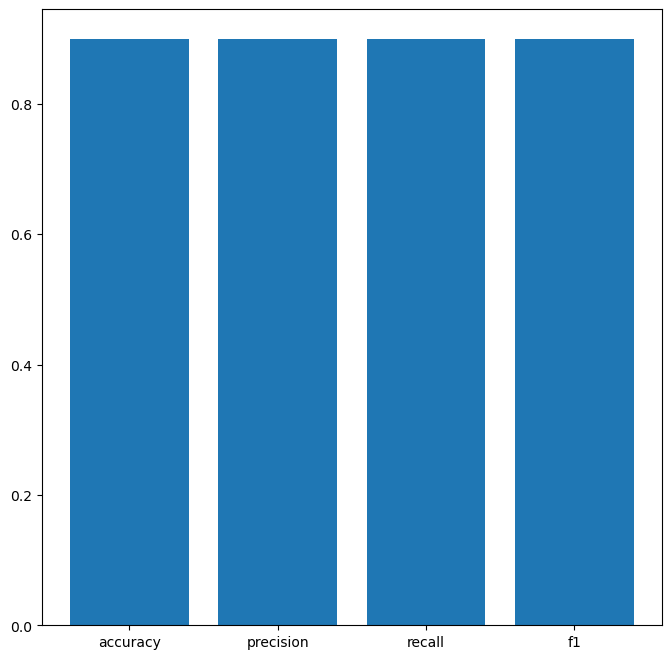

In [43]:
fig, ax = plt.subplots(figsize = (8,8))
ax = plt.bar(range(len(rs_metrics)),list(rs_metrics.values()),tick_label = list(rs_metrics.keys()))

### Getting prediction probability

In [44]:
rs_y_prob = rs_RF.predict_proba(X_test)
print(rs_y_prob)


[[0.         1.         0.         0.         0.         0.        ]
 [0.825      0.05       0.         0.125      0.         0.        ]
 [0.         0.06666667 0.         0.93333333 0.         0.        ]
 [1.         0.         0.         0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.        ]
 [0.05       0.35       0.         0.6        0.         0.        ]
 [0.         0.82       0.06666667 0.11333333 0.         0.        ]
 [0.         0.25714286 0.24166667 0.         0.         0.50119048]
 [0.         0.9        0.         0.         0.         0.1       ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.05       0.72       0.05       0.         0.18      ]
 [0.         0.85       0.         0.1        0.         0.05      ]
 [0.         0.83333333 0.         0.         0.         0.16666667]
 [0.         0.96666667 0.        

In [63]:
prob=list(map(max,rs_y_prob))

In [64]:
tp = list(map(np.argmax,rs_y_prob))

In [77]:
X_test

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
610,1,300.7,311.1,1427,50.3,137
174,0,302.1,310.7,1294,62.4,101
67,1,299.1,308.8,1320,67.5,20
168,1,302.2,310.6,1348,48.4,161
275,1,302.1,310.7,1314,52.8,8
...,...,...,...,...,...,...
290,1,302.7,310.5,1263,67.8,197
211,1,297.3,308.2,1396,52.7,212
448,1,299.3,309.0,1786,23.5,100
766,1,298.9,308.5,1503,40.6,145


In [78]:
X_test['pred_type'] = tp
X_test['pred_prob'] = prob
X_test

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],pred_type,pred_prob
610,1,300.7,311.1,1427,50.3,137,1,1.000000
174,0,302.1,310.7,1294,62.4,101,0,0.825000
67,1,299.1,308.8,1320,67.5,20,3,0.933333
168,1,302.2,310.6,1348,48.4,161,0,1.000000
275,1,302.1,310.7,1314,52.8,8,0,1.000000
...,...,...,...,...,...,...,...,...
290,1,302.7,310.5,1263,67.8,197,2,0.633333
211,1,297.3,308.2,1396,52.7,212,2,0.470000
448,1,299.3,309.0,1786,23.5,100,1,1.000000
766,1,298.9,308.5,1503,40.6,145,1,1.000000


In [79]:
X_test['act_type']=y_test

In [80]:
X_test

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],pred_type,pred_prob,act_type
610,1,300.7,311.1,1427,50.3,137,1,1.000000,1
174,0,302.1,310.7,1294,62.4,101,0,0.825000,0
67,1,299.1,308.8,1320,67.5,20,3,0.933333,3
168,1,302.2,310.6,1348,48.4,161,0,1.000000,0
275,1,302.1,310.7,1314,52.8,8,0,1.000000,0
...,...,...,...,...,...,...,...,...,...
290,1,302.7,310.5,1263,67.8,197,2,0.633333,0
211,1,297.3,308.2,1396,52.7,212,2,0.470000,2
448,1,299.3,309.0,1786,23.5,100,1,1.000000,1
766,1,298.9,308.5,1503,40.6,145,1,1.000000,1
